<a href="https://colab.research.google.com/github/goitstudent123/ml-fundamentals-and-applications/blob/main/dz_topic_8_3_HAS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# 1. Здійсніть імпорт необхідних пакетів.

!pip install category_encoders

import numpy as np
import pandas as pd

from datetime import datetime

from category_encoders import TargetEncoder

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer


In [40]:
# 2. Завантажте тренувальний mod_04_hw_train_data.csv і валідаційний mod_04_hw_valid_data.csv набори даних, доступні в репозиторії.
# Цільова змінна — рівень заробітної плати співробітників (Salary).

train_url = "https://raw.githubusercontent.com/goitacademy/MACHINE-LEARNING-NEO/refs/heads/main/datasets/mod_04_hw_train_data.csv"
valid_url = "https://raw.githubusercontent.com/goitacademy/MACHINE-LEARNING-NEO/refs/heads/main/datasets/mod_04_hw_valid_data.csv"

train_df = pd.read_csv(train_url)
valid_df = pd.read_csv(valid_url)

TARGET_COL = "Salary"

print("Train shape:", train_df.shape)
print("Valid shape:", valid_df.shape)
print("Target column present in train:", TARGET_COL in train_df.columns)
print("Target column present in valid:", TARGET_COL in valid_df.columns)



Train shape: (249, 9)
Valid shape: (7, 9)
Target column present in train: True
Target column present in valid: True


In [41]:
# 3. Виконайте первинний дослідницький аналіз даних (EDA), визначте придатність і доцільність використання наявних в наборі ознак для моделювання.

TARGET_COL = "Salary"

# Remove missing values
train_df = train_df.dropna()
valid_df = valid_df.dropna()

# Drop unnecessary columns
cols_to_drop = ["Name", "Phone_Number", "Date_Of_Birth"]
train_df = train_df.drop(columns=cols_to_drop)
valid_df = valid_df.drop(columns=cols_to_drop)

# Separate features and target
numeric_cols = train_df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove(TARGET_COL)

categorical_cols = train_df.select_dtypes(include=["object"]).columns.tolist()

feature_cols = numeric_cols + categorical_cols

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET_COL].copy()

X_valid = valid_df[feature_cols].copy()
y_valid = valid_df[TARGET_COL].copy()

print("Numeric features:", numeric_cols)
print("Categorical features:", categorical_cols)


Numeric features: ['Experience']
Categorical features: ['Qualification', 'University', 'Role', 'Cert']


In [42]:
# 4. Виконайте обробку числових ознак (трансформацію / нормалізацію за допомогою об’єктів StandardScaler або Pow
#    або об’єктів з пакета category_encoders).

X_train = train_df[feature_cols].copy()
y_train = train_df[TARGET_COL].copy()

X_valid = valid_df[feature_cols].copy()
y_valid = valid_df[TARGET_COL].copy()


preprocessor = ColumnTransformer(
    transformers=[
        ("num", "passthrough", numeric_cols),
        ("cat", TargetEncoder(), categorical_cols),
    ],
    remainder="drop",
)


In [43]:
# 5. Побудуйте модель за допомогою об'єкта KNeighborsRegressor з пакета sklearn.

pipe = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("power", PowerTransformer()),
        ("model", KNeighborsRegressor()),
    ]
)

param_grid = {
   "model__n_neighbors": list(range(15, 41, 2)),
   "model__weights": ["distance"],
   "model__p": [2],
}



grid = GridSearchCV(
    pipe,
    param_grid,
    scoring="neg_mean_absolute_percentage_error",
    cv=5,
    n_jobs=-1,
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV MAPE:", f"{(-grid.best_score_):.2%}")

best_model = grid.best_estimator_


Best params: {'model__n_neighbors': 25, 'model__p': 2, 'model__weights': 'distance'}
Best CV MAPE: 2.26%


In [44]:
# 6. Виконайте аналогічні етапи обробки і підготовки даних для валідаційного набору, подібно до того, як ми це робили у темі «Метод опорних векторів (SVM)»
# в розділі «Практика застосування SVM-класифікатора. Навчання й оцінка моделі. Приклад використання моделі)» .

y_pred_valid = best_model.predict(X_valid)

print("Predictions generated:", len(y_pred_valid))
print("First 10 predictions:", y_pred_valid[:10])


Predictions generated: 7
First 10 predictions: [110057.70296241  90000.          92000.         116500.
  74100.         107098.14138835  81500.        ]


In [45]:
# 7. Отримайте прогноз заробітної плати для нових об’єктів (працівників) із валідаційного набору, розрахуйте доцільні метрики точності регресійної моделі.

# Predict on validation set
y_pred = best_model.predict(X_valid)

# Metrics
mape = np.mean(np.abs((y_valid - y_pred) / y_valid)) * 100
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

print("Validation metrics:")
print(f"MAPE: {mape:.2f}%")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2:   {r2:.4f}")


Validation metrics:
MAPE: 6.13%
MAE:  5150.8349
RMSE: 6665.5585
R2:   0.8245


In [46]:
import pandas as pd
import numpy as np

# Create comparison table
errors_df = pd.DataFrame({
    "Actual": y_valid.reset_index(drop=True),
    "Predicted": y_pred,
})

# Calculate errors
errors_df["Error"] = errors_df["Predicted"] - errors_df["Actual"]
errors_df["Absolute_Error"] = np.abs(errors_df["Error"])
errors_df["Absolute_Percent_Error"] = (
    errors_df["Absolute_Error"] / errors_df["Actual"] * 100
)

# Sort by biggest mistake
errors_df = errors_df.sort_values("Absolute_Percent_Error", ascending=False)

errors_df

,Actual,Predicted,Error,Absolute_Error,Absolute_Percent_Error
6,69800,81500.000000,11700.000000,11700.000000,16.762178
5,97300,107098.141388,9798.141388,9798.141388,10.070032
2,98900,92000.000000,-6900.000000,6900.000000,6.976744
1,84800,90000.000000,5200.000000,5200.000000,6.132075
4,75800,74100.000000,-1700.000000,1700.000000,2.242744
0,109300,110057.702962,757.702962,757.702962,0.693232
3,116500,116500.000000,0.000000,0.000000,0.000000


<Axes: >

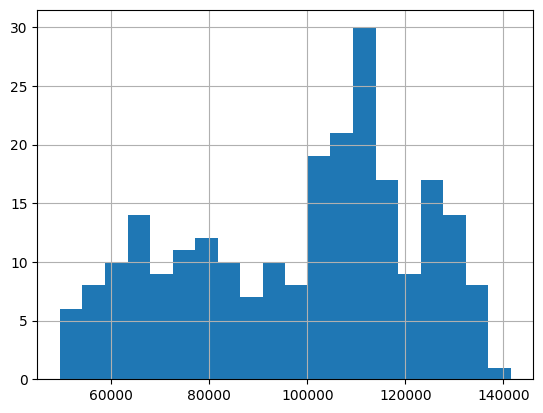

In [48]:
train_df["Salary"].describe()
train_df["Salary"].hist(bins=20)

**Висновки**

У роботі було побудовано модель регресії KNN з використанням TargetEncoder для кодування категоріальних ознак та PowerTransformer для масштабування числових даних.

Фінальна модель показала такі результати:

* Найкращий CV MAPE: 2.26%
* Validation MAPE: 6.13%
* MAE: 5150.83
* RMSE: 6665.56
* R²: 0.8245

Різниця між CV та validation метриками пояснюється невеликим розміром валідаційної вибірки (7 спостережень). Один випадок із відносно низькою зарплатою (69 800) суттєво вплинув на показник MAPE, оскільки метрика є чутливою до відносних похибок на малих значеннях.

Загалом модель демонструє стабільну узгодженість між крос-валідацією та валідаційним набором, а значення R² = 0.82 свідчить про добру здатність пояснювати варіацію цільової змінної.

Можна зробити висновок, що застосований підхід є коректним, а отримані результати відповідають **очікуваному рівню якості для даного набору даних.**